# Café com Analytics: Problema de classificação

Juntamente com Adachi, vamos explorar o [dataset do Titanic](https://www.kaggle.com/c/titanic), Ao longo desse desenvolvimento, usaremos as seguintes metodologias para o trabalho em equipe:
1. [Git flow](https://guides.github.com/introduction/flow/); e
1. [CRISP-ML(Q)](https://arxiv.org/abs/2003.05155).

## Formato deste notebook:

Logo no final desta célula, estará a conclusão deste notebook e a conclusão estará datada, pois ela é mutável de acordo com o andamento da análise e criação do modelo.

# Business and data undertanding

O problema proposto é ***“what sorts of people were more likely to survive?”***. Ou seja, trataremos de um problema de classificação binária (sobreviveu ou não) e nosso modelo tem também a missão de fazer inferências sobre a influência dos atributos preditores sobre a resposta.

In [5]:
import os

import pandas as pd
import numpy as np
# from feature_engine import categorical_encoders as ce

import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

os.chdir("../src/")
from utils.data_describe import DataDescribe as dd

raw_path = "../data/raw/"
external_path = "../data/external/"
interim_path = "../data/interim/"
reports_path = "../reports/"

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# load the autoreload extension
%load_ext autoreload

# Set extension to reload modules every time before executing code
%autoreload 2

In [6]:
# List all files in a directory using scandir()
with os.scandir(raw_path) as entries:
    for entry in entries:
        if entry.is_file():
            print(entry.name)

.gitkeep
train.csv
test.csv
gender_submission.csv


## Explorando dados

In [7]:
df_train = pd.read_csv(raw_path+'train.csv', index_col="PassengerId")
df_test = pd.read_csv(raw_path+'test.csv', index_col="PassengerId")

print(f"""O dataframe df_train possui:
- {df_train.shape[0]} registros; e
- {df_train.shape[1]} atributos, incluindo a variável resposta ("Survived").
""")

print(f"""O dataframe df_test possui:
- {df_test.shape[0]} registros; e
- {df_test.shape[1]} atributos, SEM a variável resposta ("Survived").
""")

df_train.head()

O dataframe df_train possui:
- 891 registros; e
- 11 atributos, incluindo a variável resposta ("Survived").

O dataframe df_test possui:
- 418 registros; e
- 10 atributos, SEM a variável resposta ("Survived").



,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
df_train['Cabin_letter'] = df_train['Cabin'].str.slice(stop=1)

In [9]:
lst_nulls = dd.serie_nulos(df_train, corte=0.001)

print(lst_nulls)

lst_nulls = lst_nulls.index.tolist()

4 atributos/features/campos possuem mais de 0.001 de valores nulos.
Cabin_letter    0.771044
Cabin           0.771044
Age             0.198653
Embarked        0.002245
dtype: float64


In [20]:
dd.cardinalidade(df_train['Survived', 'Pclass', 'Name'])

KeyError: ('Survived', 'Pclass', 'Name')

### É possível inferir valores para os nulos de 'Cabin'?

In [12]:
def missing_indicator(df, num_features):    
    for feature in num_features:
        if df[feature].isnull().sum()==0:
            continue
        else:
            new_feature = 'missing_'+feature
            df[new_feature] = np.where(df[feature].isnull(), 1, 0)
    return df

df_train = missing_indicator(df_train, lst_nulls)

df_train.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_letter,missing_Cabin_letter,missing_Cabin,missing_Age,missing_Embarked
PassengerId,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,NaN,1,1,0,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,0,0,0,0


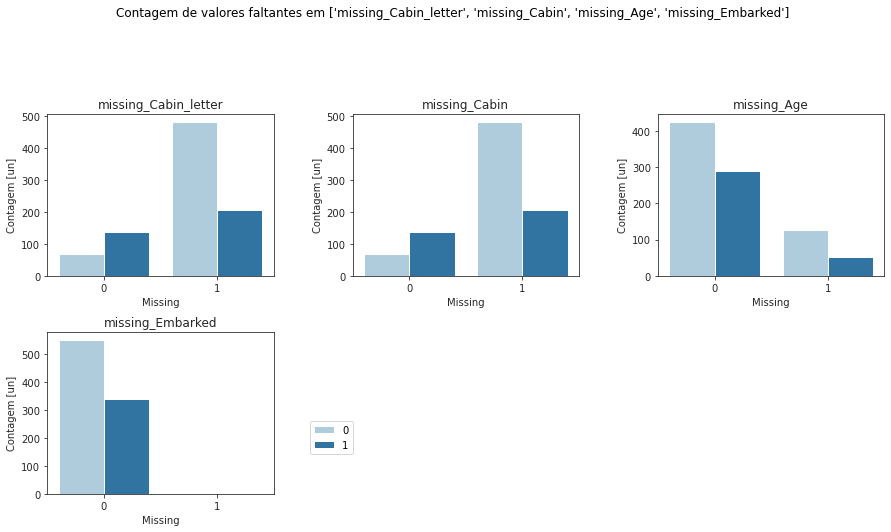

In [7]:
f = plt.figure(figsize=(15, 15))
f.suptitle(f"""Contagem de valores faltantes em {[feature for feature in df_train.columns if 'missing_' in feature]}""")
sns.set_palette("Paired")
gs = f.add_gridspec(nrows=4, ncols=3, wspace=.35, hspace=.35);

row = col = 0
for i, feature in enumerate([feature for feature in df_train.columns if 'missing_' in feature]):
    with sns.axes_style("ticks"):
        ax = f.add_subplot(gs[row, col])
        ax = sns.countplot(x=feature, hue='Survived', data=df_train)
        ax.set(title=feature, xlabel='Missing', ylabel='Contagem [un]')
        ax.get_legend().set_visible(False)
        if (i+1)%3!=0:
            col += 1
        else:
            col = 0
            row+=1

plt.legend(bbox_to_anchor=(1.35, 0.45),borderaxespad=0);

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Survived              891 non-null    int64  
 1   Pclass                891 non-null    int64  
 2   Name                  891 non-null    object 
 3   Sex                   891 non-null    object 
 4   Age                   714 non-null    float64
 5   SibSp                 891 non-null    int64  
 6   Parch                 891 non-null    int64  
 7   Ticket                891 non-null    object 
 8   Fare                  891 non-null    float64
 9   Cabin                 204 non-null    object 
 10  Embarked              889 non-null    object 
 11  Cabin_letter          204 non-null    object 
 12  missing_Cabin_letter  891 non-null    int32  
 13  missing_Cabin         891 non-null    int32  
 14  missing_Age           891 non-null    int32  
 15  missing_Embarked      8

In [13]:
profile = ProfileReport(df_train, title="Relatório de Estatística Descritiva", explorative=True)

# profile.to_notebook_iframe();

# plotando com widgets
profile.to_widgets()

# É possível exportar o relatório de análise estatística descritiva para um HTML.
profile.to_file(reports_path+"relatorio_estatistica_descritiva.html")

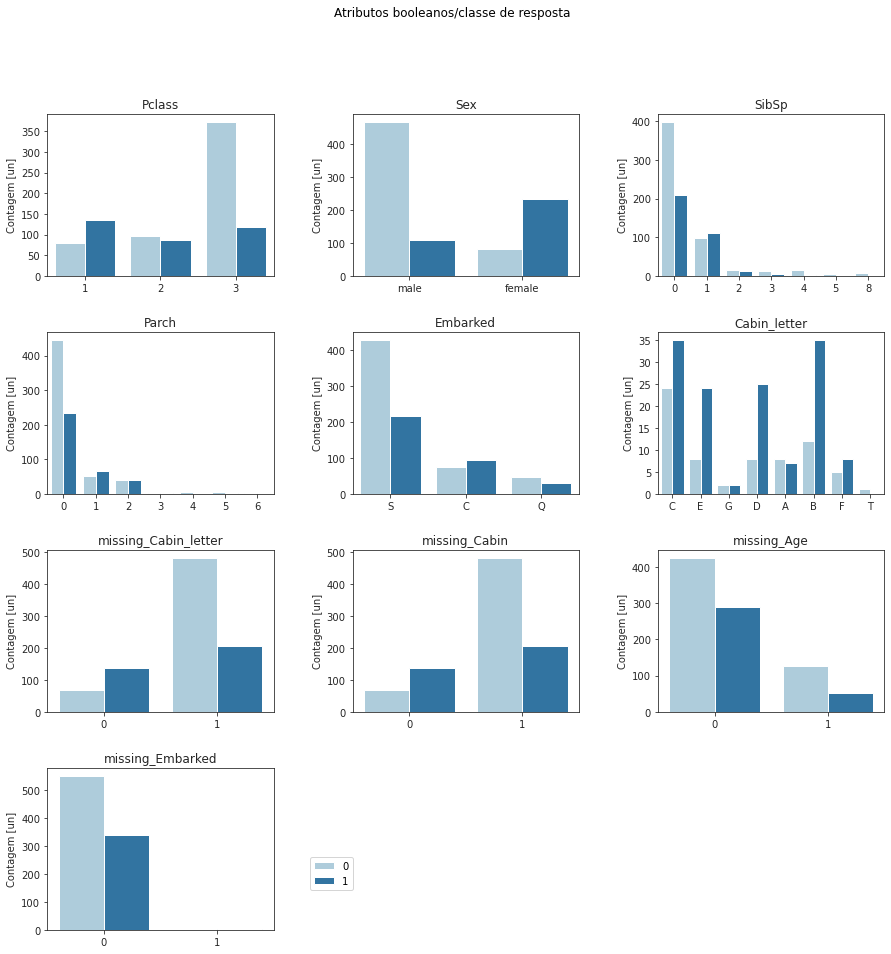

In [14]:
lst_cat = list(df_train.select_dtypes(include=['object','int','int32','int64']).columns)
lst_cat.remove('Cabin')
lst_cat.remove('Survived')
lst_cat.remove('Name')
lst_cat.remove('Ticket')

f = plt.figure(figsize=(15, 15))
f.suptitle('Atributos booleanos/classe de resposta')
sns.set_palette("Paired")

gs = f.add_gridspec(nrows=4, ncols=3, wspace=.35, hspace=.35
#                     width_ratios=widths, height_ratios=heights
                   );

row = col = 0
for i, feature in enumerate(lst_cat):
    with sns.axes_style("ticks"):
        ax = f.add_subplot(gs[row, col])
        ax = sns.countplot(x=feature, hue='Survived', data=df_train)
        ax.set(title=feature, xlabel='', ylabel='Contagem [un]')
        ax.get_legend().set_visible(False)
        if (i+1)%3!=0:
            col += 1
        else:
            col = 0
            row+=1

plt.legend(bbox_to_anchor=(1.35, 0.45),borderaxespad=0);

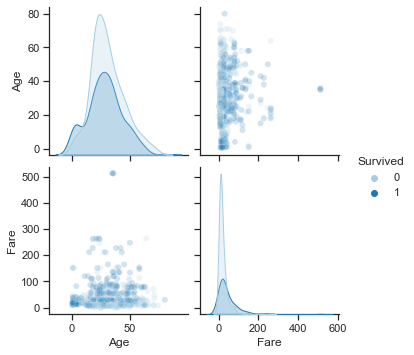

In [15]:
lst_cont = ['Survived', 'Age', 'Fare']

sns.set(style="ticks")
sns.set_palette("Paired")

ax = sns.pairplot(df_train[lst_cont], hue="Survived", plot_kws={'alpha':0.2})

## Roteiro para a transformação de dados:

1. Criar feature para Cabin_letter
1. Criar features 'missing_Cabin_letter', 'missing_Cabin', 'missing_Age', 'missing_Embarked'
1. Se o atributo for categórico e não numérico, colocaremos "missing"
1. Se o atributo for numérico, trocaremos pela mediana.

In [ ]:
'../data/processed'